In [44]:
## Import package
import numpy as np

# import pandas as pd
# from __future__ import print_function, division
# import os
import torch
# from skimage import io, transform
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets, models
# import torchvision
# from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import copy
from collections import namedtuple
%matplotlib inline
import matplotlib.pyplot as plt
# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode

### Load Raw Data

In [2]:
import csv
with open('socialmedia-disaster-tweets-DFE-cleaned2.csv', newline='', encoding="utf8", errors='ignore') as csvfile:
    data = list(csv.reader(csvfile))

data = np.array(data)
data.shape

(10876, 2)

In [3]:
## Load Train, Dev and Test Label
train_size = 8000
val_size = 2876
#test_size = 876
#trainX = data[0:train_size,1]
trainY = data[0:train_size,0].astype(float)
#devX = data[train_size:(train_size+val_size),1]
valY = data[train_size:(train_size+val_size),0].astype(float)
#testX = data[(train_size+val_size):(train_size+val_size+test_size),1]
#testY = data[(train_size+val_size):(train_size+val_size+test_size),0].astype(float)
dataX = data[:,1]
# testX = loader.test

### Transform Loaded Data 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 50, stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(dataX)

In [5]:
X.shape

(10876, 314)

In [6]:
## Load Train, Dev and Test X
trainX = X[0:train_size]
valX = X[train_size:(train_size+val_size)]
#testX = X[(train_size+val_size):(train_size+val_size+test_size)]

In [7]:
trainX = trainX.toarray()
valX = valX.toarray()
#testX = testX.toarray()

In [8]:
trainx = torch.from_numpy(trainX).float()
valx = torch.from_numpy(valX).float()
#testx = torch.from_numpy(testX).float()
trainy = torch.from_numpy(trainY)
valy = torch.from_numpy(valY)
#testy = torch.from_numpy(testY)

In [9]:
class DataLoader(object):
    def __init__(self,X,Y):
        self.x = X
        self.y = Y
    
    def __getitem__(self,index):
        x, y = self.x[index], self.y[index]
        return x,y
    
    def __len__(self):
        return len(self.x)

In [10]:
train_loader = DataLoader(trainx,trainy)
val_loader = DataLoader(valx, valy)
#test_loader = DataLoader(testx,testy)

In [11]:
len(train_loader)

8000

In [12]:
len(val_loader)

2876

### Define Train Structure

In [13]:
class TwitterModel(nn.Module):
    def __init__(self):
        super(TwitterModel, self).__init__()
        self.layer1 = nn.Linear(314, 728)
        self.bnorm1 = nn.BatchNorm1d(728)
        self.dp1 = nn.Dropout(p=0.2)
        
        self.layer2 = nn.Linear(728, 1024)
        self.bnorm2 = nn.BatchNorm1d(1024)
        self.dp2 = nn.Dropout(p=0.1)
        
        self.layer3 = nn.Linear(1024, 728)
        self.bnorm3 = nn.BatchNorm1d(728)
        self.dp3 = nn.Dropout(p=0.1)
        
        self.layer4 = nn.Linear(728, 600)
        self.bnorm4 = nn.BatchNorm1d(600)
        self.dp4 = nn.Dropout(p=0.1)
        
        self.layer5 = nn.Linear(600, 512)
        self.bnorm5 = nn.BatchNorm1d(512)
        self.dp5 = nn.Dropout(p=0.1)
        
        self.layer6 = nn.Linear(512, 256)
        self.bnorm6 = nn.BatchNorm1d(256)
        self.dp6 = nn.Dropout(p=0.1)
        
        self.layer7 = nn.Linear(256, 2)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dp1(self.bnorm1(x))
            
        x = F.relu(self.layer2(x))
        x = self.dp2(self.bnorm2(x))
        
        x = F.relu(self.layer3(x))
        x = self.dp3(self.bnorm3(x))
        
        x = F.relu(self.layer4(x))
        x = self.dp4(self.bnorm4(x))
        
        x = F.relu(self.layer5(x))
        x = self.dp5(self.bnorm5(x))
        
        x = F.relu(self.layer6(x))
        x = self.dp6(self.bnorm6(x))
        
        x = F.log_softmax(self.layer7(x))
        return x
    
print(TwitterModel())
twittermodel = TwitterModel()

TwitterModel(
  (layer1): Linear(in_features=314, out_features=728, bias=True)
  (bnorm1): BatchNorm1d(728, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2)
  (layer2): Linear(in_features=728, out_features=1024, bias=True)
  (bnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.1)
  (layer3): Linear(in_features=1024, out_features=728, bias=True)
  (bnorm3): BatchNorm1d(728, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp3): Dropout(p=0.1)
  (layer4): Linear(in_features=728, out_features=600, bias=True)
  (bnorm4): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp4): Dropout(p=0.1)
  (layer5): Linear(in_features=600, out_features=512, bias=True)
  (bnorm5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp5): Dropout(p=0.1)
  (layer6): Linear(in_features=512, out_features=256, bias=True)
  (bnorm

### Define Batch Size, finalize Loader Object

In [14]:
# Add dataset to dataloader that handles batching
batch_size = 64
# train_size = len(train.data)
# val_size = len(dev.data)
# test_size = test_data.test_data.shape[0]
# batch_size = 100

train_loader = torch.utils.data.DataLoader(train_loader, 
                                           batch_size=batch_size,
                                           shuffle = True
                                           )
val_loader = torch.utils.data.DataLoader(val_loader, 
                                           batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

#test_loader = torch.utils.data.DataLoader(test_loader, 
#                                           batch_size=batch_size,
#                                           shuffle = False)

# Setup metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

### Define a Loss function and optimizer

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(twittermodel.parameters(), lr=0.001)
# optimizer = optim.SGD(speechmodel.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [16]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
#print(device)

In [18]:
# train_size = len(train.data)
# val_size = len(dev.data)
# train_size,val_size

### Train Function

In [40]:
# def validation_inference(model, loader, n):
#     correct = 0
#     for data, label in loader:
#         model = model.cuda()
#         out = model(data)
# #         pred = out.data.max(1, keepdim=True)[1]
# #         predicted = pred.eq(Y.data.view_as(pred))
#         _, predicted = torch.max(out,1)
# #         correct += sum([predicted[i]==label[i] for i in range(len(predicted))])
#         correct += torch.sum(predicted == label)
#     return correct.double() / n

def train_epoch(model, train_loader, val_loader, criterion, optimizer, epochs,train_size,val_size):
    ini_time = time.time()
    
    # initial weight
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # metrics record statistics
    metrics = []
    acc = []
    v_acc = []
    # loop through each epoch
    for epoch in range(epochs):
            # set model to train model
        model.train()
        #model.to(device)
        
        scheduler.step()
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        # initialize the running loss to 0
        epoch_loss = 0.0
        correct = 0
        start_time = time.time()
        
        for batch_idx, (data, label) in enumerate(train_loader):
            
            # refresh the parameter gradients
            optimizer.zero_grad()
            if batch_idx % 50 == 0:
                print(' Progress %s: %d/%d'%(epoch,batch_idx,len(train_loader)))
            #data = data.to(device)
            #label = label.long().to(device)
            label = label.long()
            # forward + backward + optimize
            outputs = model(data)
            _, predicted = torch.max(outputs,1)
            correct += torch.sum(predicted == label)
            loss = criterion(outputs, label)
            
            loss.backward()
            optimizer.step()
            
            # accumulate loss
            epoch_loss += loss.item() 
        
        # end of an epoch
        end_time = time.time()
        print('Epoch %d Training Loss: '%(epoch+1), epoch_loss, 'Time: ',end_time - start_time, 's')
        
        # print statistics
        total_loss = epoch_loss/train_size
        train_error = 1.0 - correct.double()/train_size
        train_acc = correct.double()/train_size
        
        
        # validation process
        val_correct = 0
        model.eval()
        
        with torch.no_grad():
            for batch_idx, (val_data, val_label) in enumerate(val_loader):

                #val_data = val_data.to(device)
                #val_label = val_label.long().to(device)
                val_label = val_label.long()
                out = model(val_data)
                _, val_predicted = torch.max(out,1)
                val_correct += torch.sum(val_predicted == val_label)
                
            val_acc = val_correct.double() / val_size
            val_error = 1.0 - val_acc

            # record best weights
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
#         print("epoch: {0}, loss: {1:.8f}".format(epoch+1, total_loss))
        print("epoch: {0}, acc: {1:.8f}".format(epoch+1, val_acc))
        metrics.append(Metric(loss=total_loss, 
                              train_error=train_error,
                              val_error=val_error))
        acc.append(train_acc)
        v_acc.append(val_acc)
    # end of total training
    time_elapsed = time.time() - ini_time
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,metrics,acc,v_acc

In [41]:
model_ft,metrics,acc,v_acc = train_epoch(twittermodel, train_loader, val_loader, criterion, optimizer, 12,train_size,val_size)

Epoch 0/11
----------
 Progress 0: 0/125


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Progress 0: 50/125
 Progress 0: 100/125
Epoch 1 Training Loss:  57.51078912615776 Time:  13.205569982528687 s
epoch: 1, acc: 0.76112656
Epoch 1/11
----------
 Progress 1: 0/125
 Progress 1: 50/125
 Progress 1: 100/125
Epoch 2 Training Loss:  57.143183559179306 Time:  13.483766078948975 s
epoch: 2, acc: 0.76460362
Epoch 2/11
----------
 Progress 2: 0/125
 Progress 2: 50/125
 Progress 2: 100/125
Epoch 3 Training Loss:  57.44853550195694 Time:  12.883489847183228 s
epoch: 3, acc: 0.76147427
Epoch 3/11
----------
 Progress 3: 0/125
 Progress 3: 50/125
 Progress 3: 100/125
Epoch 4 Training Loss:  57.3496273458004 Time:  13.1963210105896 s
epoch: 4, acc: 0.75904033
Epoch 4/11
----------
 Progress 4: 0/125
 Progress 4: 50/125
 Progress 4: 100/125
Epoch 5 Training Loss:  57.3780662715435 Time:  13.121220111846924 s
epoch: 5, acc: 0.76321280
Epoch 5/11
----------
 Progress 5: 0/125
 Progress 5: 50/125
 Progress 5: 100/125
Epoch 6 Training Loss:  57.401452511548996 Time:  13.388077020645142 s
e

In [42]:
acc

[tensor(0.7935, dtype=torch.float64),
 tensor(0.7959, dtype=torch.float64),
 tensor(0.7954, dtype=torch.float64),
 tensor(0.7963, dtype=torch.float64),
 tensor(0.7991, dtype=torch.float64),
 tensor(0.7934, dtype=torch.float64),
 tensor(0.7967, dtype=torch.float64),
 tensor(0.7976, dtype=torch.float64),
 tensor(0.7980, dtype=torch.float64),
 tensor(0.7965, dtype=torch.float64),
 tensor(0.7974, dtype=torch.float64),
 tensor(0.7963, dtype=torch.float64)]

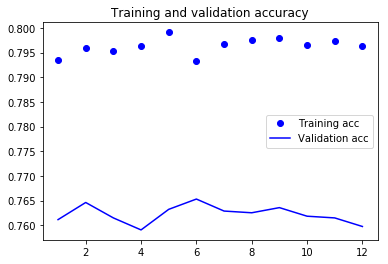

In [45]:
# plot the accuracy rates for each epoch on training and validation data
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, v_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()